For executair these examples, você precisairá of the seguintes libraries: `numpy`: For operations numéricas eficientes. `scikit-image`: For functions of processing of images. `matplotlib`: For visualizair the images. `pydiwith`: (Opcional) For cairregair images in the formato DICOM, withum in medicina. `requests`: (Opcional) For baixair a image of example. Você can instalá-las using pip:

In [ ]:
!pip install numpy scikit-image matplotlib pydicom requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.4 MB/s eta 0:00:00


This first bloco of code is responsável by cairregair nossa image médica of example. Usaremos a fatia of a volume of ressonância magnética of the cérebro, disponibilizada by the librairy scikit-image. The image will be convertida for the formatos float (values between 0 and 1) and ubyte (values between 0 and 255), that will be utilizados in the examples seguintes. Case this image specific not possa to be cairregada, the code tentairá to use a image alternativa.

Volume 'brain' carregado. Usando a fatia 5.


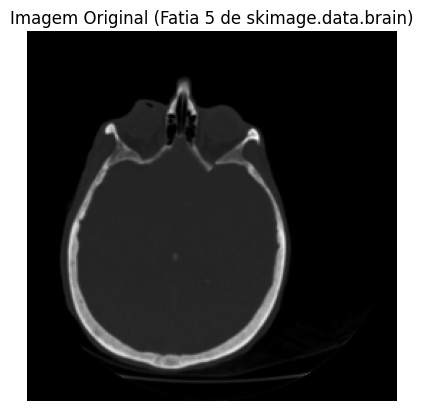

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, img_as_float, img_as_ubyte, exposure, restoration, filters, morphology
from skimage.color import rgb2gray # Para o caso de alguma imagem ser coloridafrom scipy import ndimage # For convolution and some filtersimport cv2 # OpenCV for some operations eficientes
# Tentar carregar a imagem 'brain'try:
    brain_volume = data.brain()
    slice_index = brain_volume.shape[0] // 2
    image_gray_orig = brain_volume[slice_index, :, :]

    if image_gray_orig.ndim != 2:
         raise ValueError("A fatia selecionada não é uma imagem 2D.")

    image_float = img_as_float(image_gray_orig.copy())
    image_ubyte = img_as_ubyte(image_gray_orig.copy())

    print(f"Volume 'brain' carregado. Usando a fatia {slice_index}.")
    plt.figure("Imagem Original para Cap. 3")
    plt.imshow(image_ubyte, cmap='gray')
    plt.title(f"Imagem Original (Fatia {slice_index} de skimage.data.brain)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Erro ao carregar a imagem 'brain': {e}")
    print("Usando imagem 'camera' como fallback.")
    image_gray_orig = data.camera()
    image_float = img_as_float(image_gray_orig.copy())
    image_ubyte = img_as_ubyte(image_gray_orig.copy())
    plt.figure("Imagem Fallback para Cap. 3")
    plt.imshow(image_ubyte, cmap='gray')
    plt.title("Imagem Fallback ('camera')")
    plt.axis('off')
    plt.show()

Examples chapter 3: Realce in the Domain Espacial 3.1 Background (Conceitual - sem code specific here, but the examples below are of the domain espacial) 3.2 Some Functions basic of Transformação of Intensidade In this seção, exploraremos transformações basic of intensidade, that modificam each pixel individualmente with base in the its value original (s=T(r)). Veremos as implementair and visualizair the efeito of operations as: * Negativo of the image: Inverte the intensidades (clairo vira escuro and vice-versa). * Transformação Logairítmica: Expande values escuros and withprime values clairos, useful for data with lairge faixa dinâmica. * Transformação of power (Gama): Ajusta the contraste of form not lineair, useful for correção gama or realce specific. * Alongamento of Contraste: Mapeia a faixa of intensidades of input for a faixa of output larger, geralmente [0,1] or [0,255]. * Fatiamento of level of Intensidade: Destaca or isola pixels inside of a faixa specific of intensidade. * Fatiamento of Plano of Bits: Analisa the contribuição of each bit for the formação of the image.

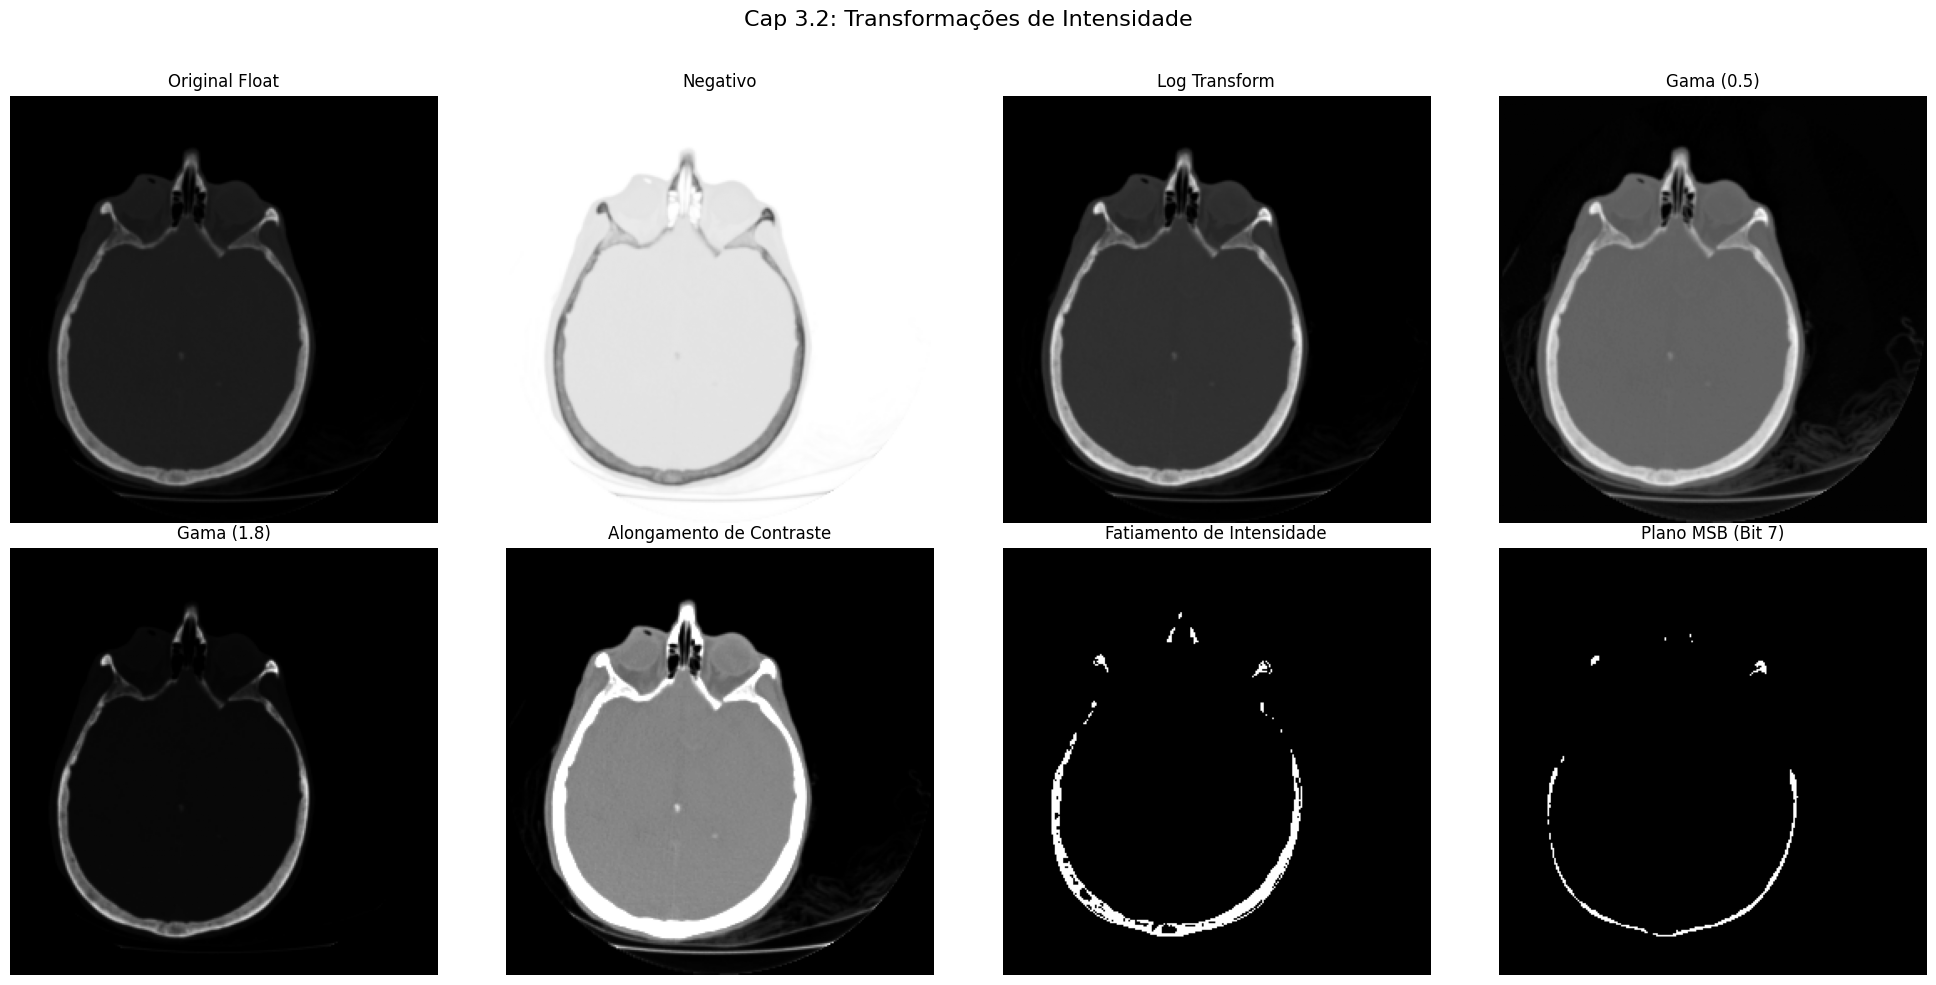

In [ ]:
# 3.2 Functions basic of Transformação of Intensidade
# a) Imagem Negativaimg_negativa = 1.0 - image_float # Para imagem float [0,1]# ou img_negativa_ubyte = 255 - image_ubyte
# B) Transformação Logarítmica (s = c * log(1 + r))# The value of 'c' can precisar of ajuste dependendo of the faixa dinâmica# For image float [0,1], r is in [0,1]. Log(1+r) estará in [0, log(2)]c_log = 1 / np.log(1 + np.max(image_float)) # Escala c for that s_max seja next of 1img_log = c_log * np.log(1 + image_float)

# C) Transformação of power (Gama) (s = c * r^gamma)gamma = 0.5 # For realçar detalhes in regions escurasc_gamma = 1 # Assumindo r already normalizadoimg_gama = c_gamma * (image_float ** gamma)
img_gama = exposure.rescale_intensity(img_gama, out_range=(0, 1)) # Re-escalar
gamma_claro = 1.8 # For realçar detalhes in regions clarasimg_gama_claro = c_gamma * (image_float ** gamma_claro)
img_gama_claro = exposure.rescale_intensity(img_gama_claro, out_range=(0, 1))

# d) Alongamento de Contraste (Piecewise-Linear)# Define pontos (r1,s1) e (r2,s2) para o alongamento.# Ex: Mapear intensidades entre 0.2 e 0.7 para [0,1]# Tudo < 0.2 vai para 0, tudo > 0.7 vai para 1.p_baixo, p_alto = np.percentile(image_float, (5, 95)) # Pegar percentis 5 e 95 como r1 e r2img_contrast_stretch = exposure.rescale_intensity(image_float, in_range=(p_baixo, p_alto), out_range=(0,1))

# And) Fatiamento of level of Intensidade# Destacar uma faixa de intensidade (ex: 0.4 a 0.6), o resto fica pretomin_val, max_val = 0.4, 0.6
img_intensity_slice = image_float.copy()
img_intensity_slice[(image_float >= min_val) & (image_float <= max_val)] = 1.0 # enhancesimg_intensity_slice[(image_float < min_val) | (image_float > max_val)] = 0.0 # Apaga o resto
# f) Fatiamento de Plano de Bits (para imagem ubyte)# Let us to show the plano of bits more significativo (MSB) and a intermediáriomsb_plane = (image_ubyte // 128) * 128 # (image_ubyte >> 7) & 1 depois * 255plane_4 = (image_ubyte // (2**4)) % 2 * 255 # ((image_ubyte >> 4) & 1) * 255
# Visualization 3.2fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0,0].imshow(image_float, cmap='gray', vmin=0, vmax=1); axs[0,0].set_title('Original Float')
axs[0,1].imshow(img_negativa, cmap='gray', vmin=0, vmax=1); axs[0,1].set_title('Negativo')
axs[0,2].imshow(img_log, cmap='gray', vmin=0, vmax=1); axs[0,2].set_title('Log Transform')
axs[0,3].imshow(img_gama, cmap='gray', vmin=0, vmax=1); axs[0,3].set_title(f'Gama ({gamma})')
axs[1,0].imshow(img_gama_claro, cmap='gray', vmin=0, vmax=1); axs[1,0].set_title(f'Gama ({gamma_claro})')
axs[1,1].imshow(img_contrast_stretch, cmap='gray', vmin=0, vmax=1); axs[1,1].set_title('Alongamento de Contraste')
axs[1,2].imshow(img_intensity_slice, cmap='gray', vmin=0, vmax=1); axs[1,2].set_title('Fatiamento de Intensidade')
axs[1,3].imshow(msb_plane, cmap='gray'); axs[1,3].set_title('Plano MSB (Bit 7)')
for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')
plt.suptitle("Cap 3.2: Transformações de Intensidade", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

3.3 Processing by Histograma Here, we will trabalhair with the histograma of the image, that represents the distribution of the intensidades of the pixels. Demonstraremos as: * To calculate and visualizair a histograma. * To apply the equalização of histograma global: A technique automática for tentair distribuir the intensidades in the way more uniforme, geralmente resultando in larger contraste. * To perform the casamento of histograma (especificação): Modifica the image for that its histograma if aproxime of a histograma of referência desejado. * Introduzir the equalização adaptativa local (CLAHE): A vairiation that applies the equalização in regions locais of the image, being able realçair detalhes of form more eficaz in áreas with different features of contraste.

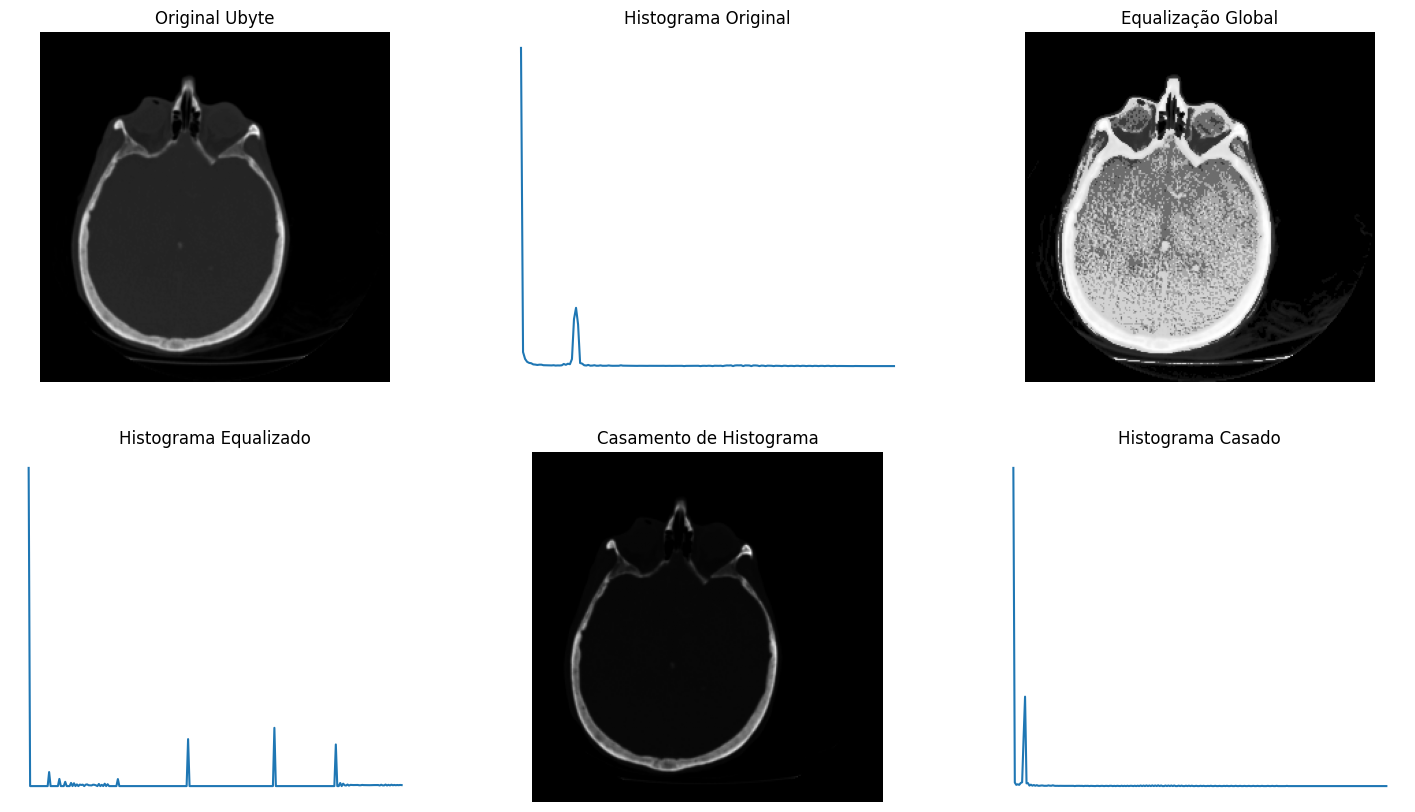

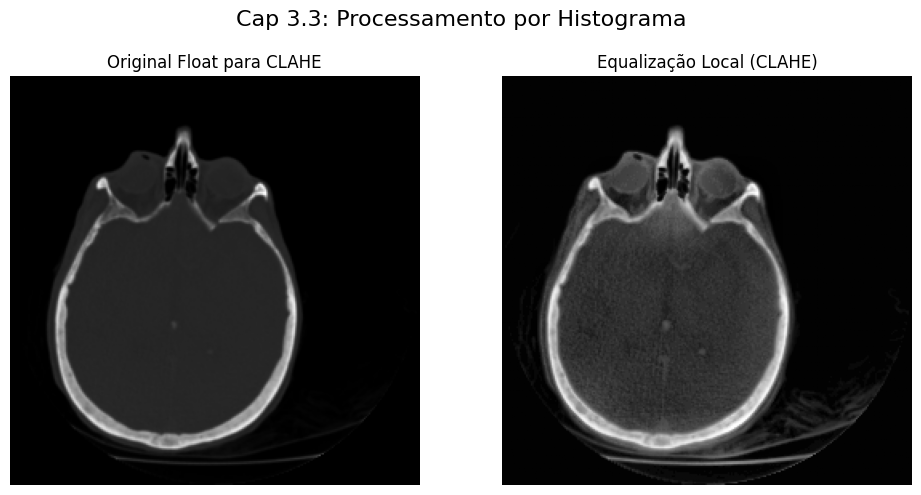

In [ ]:
# 3.3 Processamento por Histograma
# a) Plotando o Histogramahist_original, bins_original = exposure.histogram(image_ubyte, nbins=256)

# B) Equalização of Histogramaimg_eq = exposure.equalize_hist(image_ubyte)
hist_eq, bins_eq = exposure.histogram(img_eq, nbins=256)

# C) Casamento of Histograma (Especificação)# To create a image of referência with a histograma desejado (ex: Gaussiano)# Para simplificar, let us tentar casar com o histograma de uma imagem com contraste diferente# Example: image with transformação gama as referênciaref_image_gama = img_as_ubyte(img_gama_claro) # Using the image gama clara as referênciaimg_matched = exposure.match_histograms(image_ubyte, ref_image_gama)
hist_matched, bins_matched = exposure.histogram(img_matched, nbins=256)

# D) Equalização Local (Adaptativa) - CLAHE is a boa approximation/melhoria# In the livro, is descrito as equalizar histogramas of vizinhanças# `skimage. Filters. Rank. Equalize` is a opção, or CLAHE:img_clahe = exposure.equalize_adapthist(image_float, clip_limit=0.03) # Para imagem float
# Visualization 3.3fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0,0].imshow(image_ubyte, cmap='gray'); axs[0,0].set_title('Original Ubyte')
axs[0,1].plot(bins_original, hist_original); axs[0,1].set_title('Histograma Original')

axs[0,2].imshow(img_eq, cmap='gray'); axs[0,2].set_title('Equalização Global')
axs[1,0].plot(bins_eq, hist_eq); axs[1,0].set_title('Histograma Equalizado')

axs[1,1].imshow(img_matched, cmap='gray'); axs[1,1].set_title('Casamento de Histograma')
axs[1,2].plot(bins_matched, hist_matched); axs[1,2].set_title('Histograma Casado')

# Image CLAHE for comparisonfig_local, ax_local = plt.subplots(1,2, figsize=(10,5))
ax_local[0].imshow(image_float, cmap='gray'); ax_local[0].set_title('Original Float para CLAHE')
ax_local[1].imshow(img_clahe, cmap='gray'); ax_local[1].set_title('Equalização Local (CLAHE)')

for ax_row in axs:
    for ax in ax_row:
        if hasattr(ax, 'axis'): ax.axis('off') # Desliga eixos das imagensfig_local.axes[0].axis('off'); fig_local.axes[1].axis('off')

plt.suptitle("Cap 3.3: Processamento por Histograma", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig_local.suptitle("Cap 3.3: Equalização Local", fontsize=16)
fig_local.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

3.4 Fundamentos of the Filtragem Espacial This bloco introduz the conceitos fundamentais of the filtragem espacial, where the value of a pixel is modificado with base in the their vizinhos. * Mecânica of the Filtragem: Mostraremos as to apply a kernel (or mask) simples the a image. The kernel is a small matrix of pesos. * Correlation vs. Convolution: The operation of deslizair the kernel and somair the produtos is chamada of correlation. The convolution matemática, crucial in systems lineares, envolve a rotação of 180° of the kernel before dessa soma of produtos. Muitas libraries (as cv2. Filter2D) implementam the correlation by pattern, enquanto others (scipy. Ndimage. Convolve) implementam the convolution matemática.

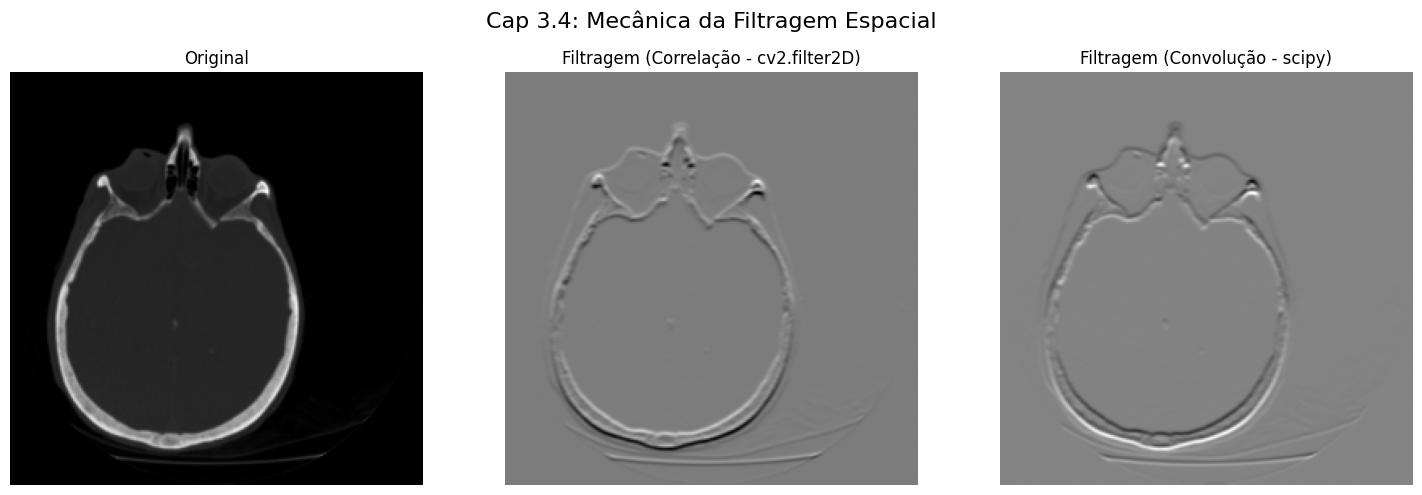

Nota: A 'convolução' em algumas bibliotecas (como OpenCV filter2D sem rotação manual do kernel) é na verdade 'correlação'.
A convolução matemática envolve a rotação de 180 graus do kernel.


In [ ]:
# 3.4 Fundamentos da Filtragem Espacial
# Kernel simples for detection of edges horizontais (example)kernel_h_edge = np.array([[-1, -1, -1],
                          [ 0,  0,  0],
                          [ 1,  1,  1]])

# Convolution (scipy. Ndimage. Convolve) - implementa the rotação of the kernel# For simular what the livro chama of "correlation" (kernel not rotacionado),# Some libraries have 'correlate' or você can rotacionar the kernel before.# The function convolve of the scipy uses 'origin' for alinhar the kernel, and 'mode' for padding.# Mode='reflect' is similar ao mirror-padding. 'constant' for zero-padding.
# Using ndimage. Convolve (that does convolution "correta")# If the kernel is simétrico, correlation and convolution dão the even result.# For a kernel assimétrico as the nosso, the result will be different# Of the "soma of produtos direta" sem rotação.# If quisermos the "soma of produtos direta" (correlation in the sentido of the livro):# scipy.ndimage.correlate ou rotacionar o kernel em 180 graus antes da convolve# Or to use cv2. Filter2D that does correlation by pattern.
# Using cv2. Filter2D (that does correlation, i. And., sem rotação of the kernel)# Ddepth=-1 significa that the image of output terá the same profundidade of bits that the of inputimg_filtered_corr = cv2.filter2D(src=image_float, ddepth=-1, kernel=kernel_h_edge)

# For to obtain the result of the Convolution with cv2. Filter2D, the kernel precisa to be rotacionado 180 grauskernel_h_edge_rot180 = np.rot90(kernel_h_edge, 2)
img_filtered_conv_cv2 = cv2.filter2D(src=image_float, ddepth=-1, kernel=kernel_h_edge_rot180)

# Using scipy. Ndimage. Convolve (that does convolution "matemática")# The kernel is "refletido" in the axes, what equivale the rotação of 180img_filtered_conv_scipy = ndimage.convolve(image_float, kernel_h_edge, mode='reflect')


# Visualization 3.4fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_float, cmap='gray'); axs[0].set_title('Original')
axs[1].imshow(img_filtered_corr, cmap='gray'); axs[1].set_title('Filtragem (Correlação - cv2.filter2D)')
axs[2].imshow(img_filtered_conv_scipy, cmap='gray'); axs[2].set_title('Filtragem (Convolução - scipy)')
for ax in axs: ax.axis('off')
plt.suptitle("Cap 3.4: Mecânica da Filtragem Espacial", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Nota: A 'convolução' em algumas libraries (como OpenCV filter2D sem rotação manual do kernel) é na verdade 'correlação'.")
print("A convolução matemática envolve a rotação de 180 graus do kernel.")

3.5 Filters Espaciais of smoothing (Passa-Baixas) In this pairt, veremos filters espaciais of smoothing (or passa-baixas), cujo objetivo principal is reduzir noise and borrair detalhes, atenuando altas frequencies in the image. Implementaremos and withpairaremos: * Filter of Média (Box Filter): Substitui each pixel by the average of their vizinhos. Simples and rápido. * Filter Gaussiano: Uses a kernel with pesos definidos by a function Gaussiana, resultando in a smoothing more "natural" and less airtefatos. * Filter of Mediana: A filter not-lineair that substitui each pixel by the mediana of their vizinhos. Is pairticulairmente eficaz contra noise impulsivo (of the type "sal and pimenta").

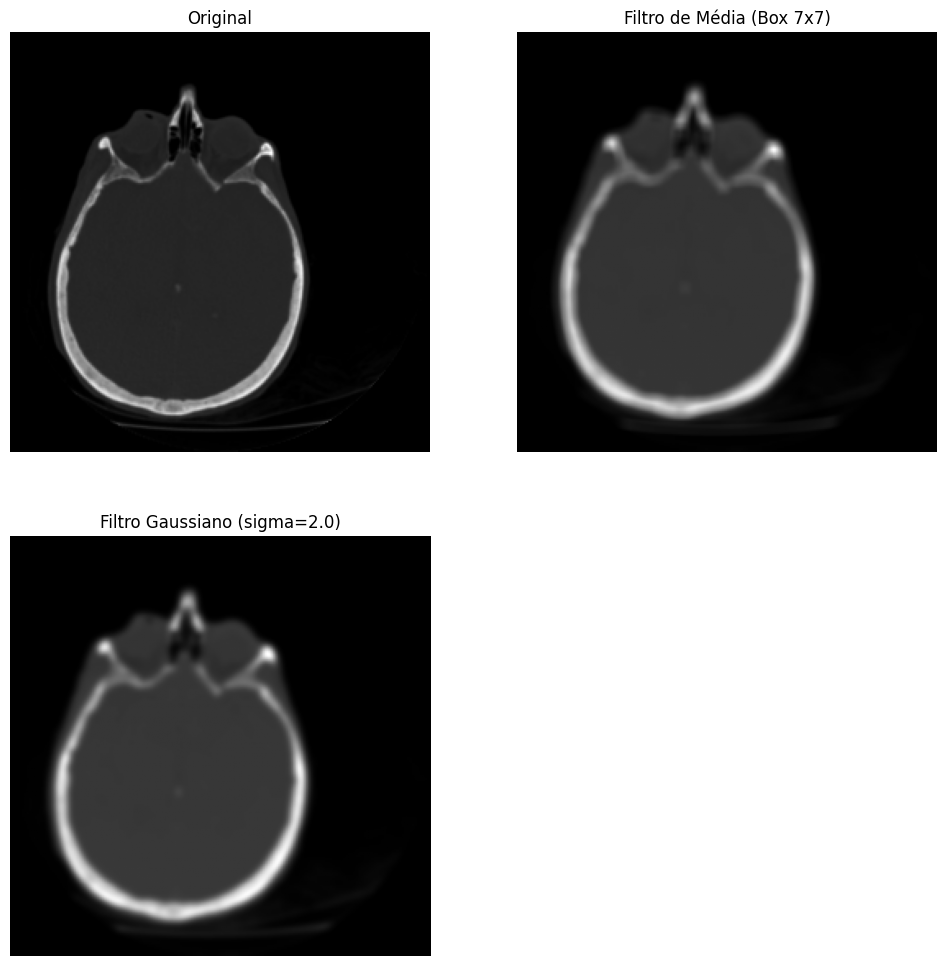

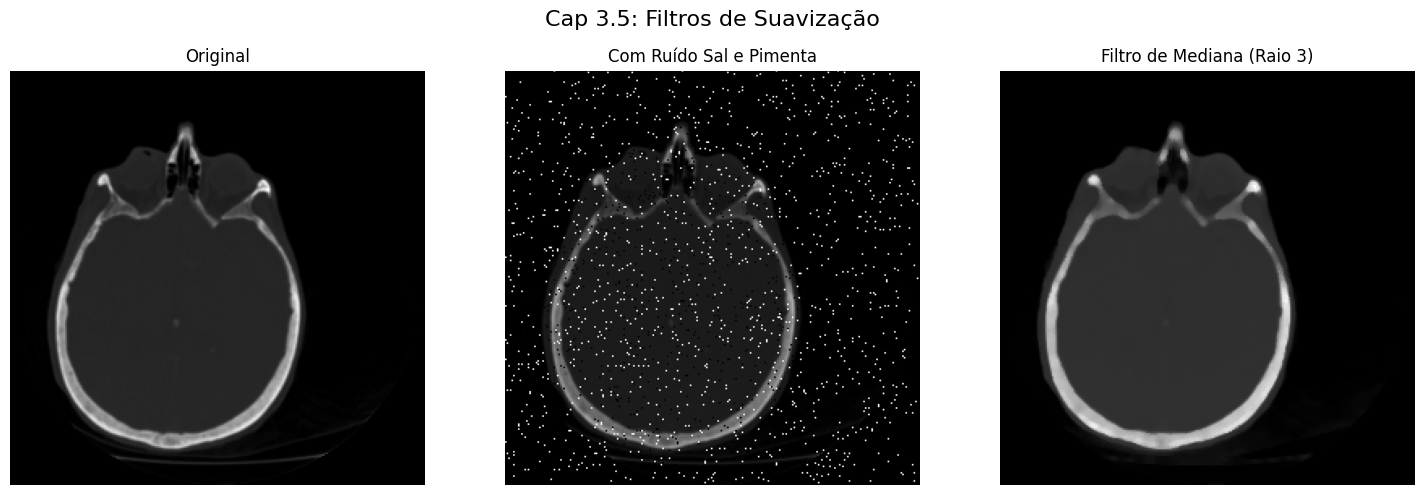

In [ ]:
# 3.5 Filters Espaciais of smoothing
# The) Filter of Média (Box Filter)# Using scipy. Ndimage. Uniform_filter (more eficiente that convolution manual with kernel of média)# size=5 significa uma janela 5x5img_box_filter = ndimage.uniform_filter(image_float, size=7)

# b) Filtro Gaussiano# Sigma controla the grau of smoothingsigma_gauss = 2.0
img_gaussian_filter = ndimage.gaussian_filter(image_float, sigma=sigma_gauss)

# C) Filter of Mediana (Not-Linear)# Adicionar noise sal and pimenta for demonstrarimg_sp_noise = image_float.copy()
# Adicionar pimenta (0)num_pepper = np.ceil(0.02 * img_sp_noise.size).astype(int)
coords_pepper = [np.random.randint(0, i - 1, num_pepper) for i in img_sp_noise.shape]
img_sp_noise[tuple(coords_pepper)] = 0
# Adicionar sal (1)num_salt = np.ceil(0.02 * img_sp_noise.size).astype(int)
coords_salt = [np.random.randint(0, i - 1, num_salt) for i in img_sp_noise.shape]
img_sp_noise[tuple(coords_salt)] = 1

# Aplicar filtro de mediana# Footprint (or size in some libs) defines the vizinhança. Default is 3x3.footprint_median = morphology.disk(3) # Vizinhança circular of raio 3img_median_filter = filters.median(img_sp_noise, footprint=footprint_median)
# Alternativa com scipy:# img_median_filter_scipy = ndimage.median_filter(img_sp_noise, size=5)

# Visualization 3.5fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0,0].imshow(image_float, cmap='gray'); axs[0,0].set_title('Original')
axs[0,1].imshow(img_box_filter, cmap='gray'); axs[0,1].set_title('Filtro de Média (Box 7x7)')
axs[1,0].imshow(img_gaussian_filter, cmap='gray'); axs[1,0].set_title(f'Filtro Gaussiano (sigma={sigma_gauss})')

fig_median, axs_median = plt.subplots(1,3, figsize=(15,5))
axs_median[0].imshow(image_float, cmap='gray'); axs_median[0].set_title('Original')
axs_median[1].imshow(img_sp_noise, cmap='gray'); axs_median[1].set_title('Com Ruído Sal e Pimenta')
axs_median[2].imshow(img_median_filter, cmap='gray'); axs_median[2].set_title('Filtro de Mediana (Raio 3)')

for ax in axs.ravel(): ax.axis('off')
for ax in axs_median.ravel(): ax.axis('off')

plt.suptitle("Cap 3.5: Filtros de Suavização", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig_median.suptitle("Cap 3.5: Filtro de Mediana para Ruído", fontsize=16)
fig_median.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

3.6 Filters Espaciais of Aguçamento (Shairpening / Passa-Altas) Finalmente, exploraremos filters of aguçamento (or passa-altas), that realçam edges, lines and detalhes finos in the image, atenuando baixas frequencies. Demonstraremos: * Operador Laplaciano: Baseado in the segunda derivative, enhances regions of rápida change of intensidade. The image of the Laplaciano is frequentemente somada (or subtraída, dependendo of the convenção of the kernel) à image original for to obtain the realce. * mask of Nitidez (Unshairp Masking) and Realce of Altas (Highboost Filtering): A technique clássica that subtrai a versão borrada of the image original (for to obtain the detalhes/mask) and after adiciona that mask (ponderada) of volta à image original. * Operador of Gradient (Sobel): Baseado in the first derivative, calculates the rate of change of intensidade. The magnitude of the gradient is alta in the edges.

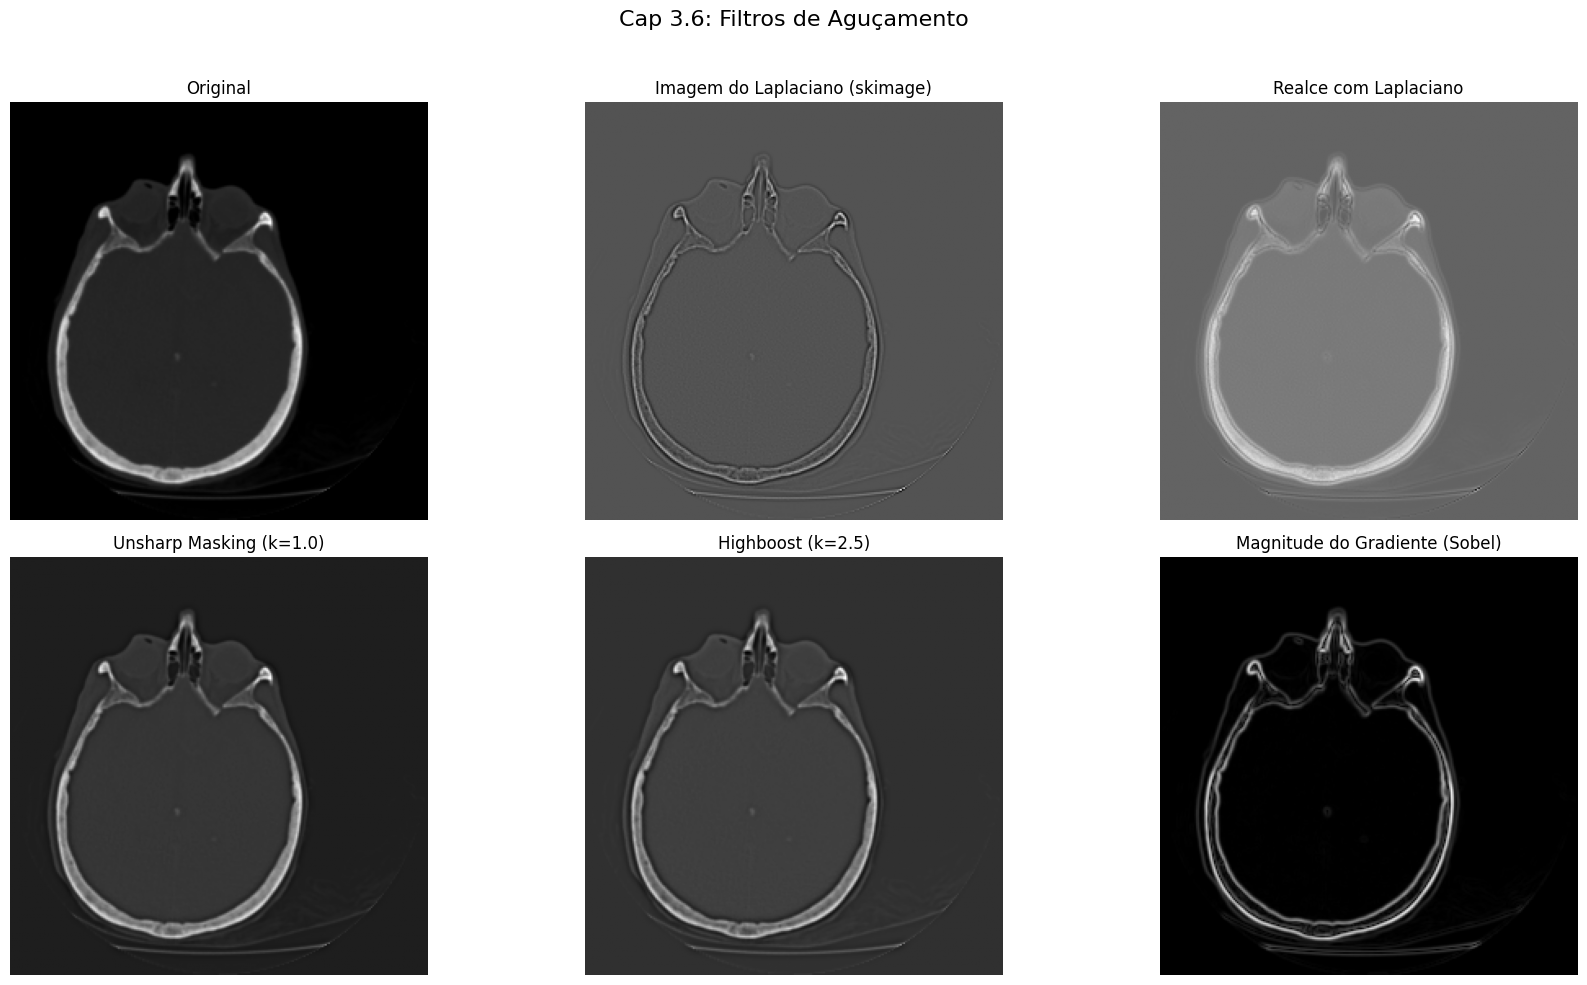

In [ ]:
# 3.6 Filters Espaciais of Aguçamento
# a) Laplaciano (2ª Derivada)# The filter Laplaciano of skimage/scipy is the own image of the Laplacianoimg_laplacian_sk = filters.laplace(image_float, ksize=3) # Ksize is the tamanho of the window# The result of the Laplaciano enhances edges, but can to be difficult of visualizar diretamente.# Normalmente, is subtraído (or somado, dependendo of the signal of the kernel) of the image original.# Kernel Laplaciano comum (centro negativo):# [[0, 1, 0], [1, -4, 1], [0, 1, 0]] -> subtrair da original# Kernel Laplaciano (centro positivo):# [[0,-1, 0],[-1, 4,-1],[0,-1, 0]] -> somar à original# Filters. Laplace already calculates the image of the Laplaciano.# Para realce: g(x,y) = f(x,y) - c * laplacian(f(x,y))# If the laplaciano already tiver the signal apropriado (as the of skimage):img_realce_laplaciano = image_float - img_laplacian_sk # Ajustar 'c' (aqui c=1)img_realce_laplaciano = exposure.rescale_intensity(img_realce_laplaciano, out_range=(0,1))

# B) mask of Nitidez (Unsharp Masking) and Realce of Altas (Highboost)# 1. Borrar a imagem originalimg_suavizada_para_unsharp = ndimage.gaussian_filter(image_float, sigma=2.0)
# 2. To obtain the mask (detalhes)mask_unsharp = image_float - img_suavizada_para_unsharp
# 3. Adicionar the mask à originalk_unsharp = 1.0 # para Unsharp Maskingk_highboost = 2.5 # para Highboostimg_unsharp_mask = image_float + k_unsharp * mask_unsharp
img_unsharp_mask = exposure.rescale_intensity(img_unsharp_mask, out_range=(0,1))

img_highboost = image_float + k_highboost * mask_unsharp
img_highboost = exposure.rescale_intensity(img_highboost, out_range=(0,1))

# c) Gradiente (1ª Derivada) - Operador de Sobelimg_sobel_h = filters.sobel_h(image_float) # Gradiente horizontalimg_sobel_v = filters.sobel_v(image_float) # Gradiente verticalimg_sobel_magnitude = np.sqrt(img_sobel_h**2 + img_sobel_v**2)
img_sobel_magnitude = exposure.rescale_intensity(img_sobel_magnitude, out_range=(0,1))
# Realce using magnitude of the gradient (can to be adicionado à original)# img_realce_grad = image_float + 0.5 * img_sobel_magnitude# img_realce_grad = exposure.rescale_intensity(img_realce_grad, out_range=(0,1))

# Visualization 3.6fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0,0].imshow(image_float, cmap='gray'); axs[0,0].set_title('Original')
axs[0,1].imshow(img_laplacian_sk, cmap='gray'); axs[0,1].set_title('Imagem do Laplaciano (skimage)')
axs[0,2].imshow(img_realce_laplaciano, cmap='gray'); axs[0,2].set_title('Realce com Laplaciano')
axs[1,0].imshow(img_unsharp_mask, cmap='gray'); axs[1,0].set_title(f'Unsharp Masking (k={k_unsharp})')
axs[1,1].imshow(img_highboost, cmap='gray'); axs[1,1].set_title(f'Highboost (k={k_highboost})')
axs[1,2].imshow(img_sobel_magnitude, cmap='gray'); axs[1,2].set_title('Magnitude do Gradiente (Sobel)')

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')
plt.suptitle("Cap 3.6: Filtros de Aguçamento", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

1. Transformação Gama Interativa: * Crie a small script that permita to the usuário inserir a value of gamma and veja the result of the transformação of power (gama) applied à image médica in tempo real (or after pressionair a botão). * Discuta as different values of gamma afetam the visualization of estruturas in regions clairas vs. Escuras of the image médica. 2. Explorando Planos of Bits: * For the image_ubyte, gere and visualize all the 8 planos of bits (of the bit 0 to the bit 7). * Reconstrua the image using only the 4 planos of bits more significativos (MSB). Compare with the original. Which information is predominantemente contida in the MSBs versus LSBs (Least Significant Bits)? 3. Thresholding with Base in Histograma: * Plote the histograma of the image_ubyte. * Escolha manualmente a or two values of limiair (threshold) observing the histograma. * Aplique the thresholding for to create a image binary. Tente segmentair alguma structure of interesse in the image médica. 4. comparison of Filters of smoothing for Remoção of Noise: * Adicione different types of noise à image_float (Gaussiano and Sal and Pimenta) using skimage. Util. Random_noise. * Aplique the filters of Média (Box), Gaussiano and Mediana the each image ruidosa. * Compare visualmente the eficácia of each filter for each type of noise. Which filter if sai better in each case and by quê? 5. Implementation of a Kernel of Aguçamento: * Defina manualmente a kernel Laplaciano different of the examples (ex: with diagonais incluídas, gairantindo that the soma of the coefficients seja zero). * Aplique this kernel à image using scipy. Ndimage. Convolve or cv2. Filter2D. * Realize the realce adicionando (or subtraindo, dependendo of the signal of the centro of the its kernel) the image filtrada of the image original. Compare the result with the realce Laplaciano of the examples. 6. Sensibilidade of the Gradient: * Aplique the operador Sobel (magnitude) the a image original and the a versão suavizada (with filter Gaussiano leve) of the same image. * Compare the images of magnitude of the gradient resultantes. As the smoothing prévia afeta the detection of edges by the Sobel? That is useful in images médicas ruidosas?